In [29]:
reset -fs

In [76]:
import re
import string
import numpy as np
import pandas as pd

# spacy for lemmatization
import spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Ntlk for stopwords
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Preprocessing

1.  Non-ascii characters are removed
2.  Use gensim's simple_preprocess to further remove special characters and punctuation, and tokenize.
3.  Remove stop words using NLTK
4.  Split data into positive, neutral, and negative reviews.
5.  Bigrams and Trigrams using Gensim on each of the above.
6.  Lemmatize using spaCy

In [31]:
# Load data
df = pd.read_csv("data/appstore_googleplay_all_reviews.csv")

# Remove NaN rows
df = df[df['text'].isna() == False]

print(df.shape)
df.head()

(6118, 10)


,name,id,title,author_name,author_uri,voteSum,voteCount,rating,text,date
0,Microsoft HealthVault,546835834,Lab Corp blood results,liver transplant patient,https://itunes.apple.com/us/reviews/id782157250,0.0,0.0,1,Lab Corp had my weekly blood work results on t...,2018-08-08 05:03:25
1,Microsoft HealthVault,546835834,What happened,Bistline,https://itunes.apple.com/us/reviews/id335994415,0.0,0.0,3,This app used to be my favorite. It would sync...,2018-06-27 14:07:45
2,Microsoft HealthVault,546835834,Great idea,Gdb&&@,https://itunes.apple.com/us/reviews/id216415940,0.0,0.0,5,I have many yrs worth of data now stored. It i...,2018-06-27 10:26:12
3,Microsoft HealthVault,546835834,Bugs after 11/14/17 update,Agw54,https://itunes.apple.com/us/reviews/id115506088,0.0,0.0,1,Worked ok until 11/14/17 update. Now you can'...,2018-03-19 06:34:58
4,Microsoft HealthVault,546835834,HeathVault,rlbarkley,https://itunes.apple.com/us/reviews/id202749603,0.0,0.0,2,I am disappointed with App because MS started ...,2018-02-05 23:30:49


In [32]:
df['text'][3]

"Worked ok until 11/14/17 update.  Now you can't put in notes-keyboard covers up note section. iPhone v10.3.3. ****** UPDATE:  After updating my iPhone 6S to the latest iOS 11.2.6, data canâ€™t be inputted.  ??? Come on guys, letâ€™s get this fixed please."

## Clean and tokenize text

In [33]:
# Prepare stopwords

stop_words = stopwords.words('english')
stop_words.extend(['app', 'use', 'subject', 'would', 'get'])

In [34]:
def clean_tokenize(text):
    text = ''.join(list(filter(lambda x: x in set(string.printable), text)))  # remove all non-ascii characters
    text = simple_preprocess(text, deacc=True) # remove all special characters, punctuation and tokenize
    #text = [word for word in text if len(word) > 2]  # remove short words
    text = [word for word in text if word not in stop_words]  # remove stopwords
    return text

In [35]:
# Tokenize words and clean up text
data_words = list(df['text'].map(clean_tokenize))
df['text_tokenized'] = data_words

print(df.head(2))

                    name         id                   title  \
0  Microsoft HealthVault  546835834  Lab Corp blood results   
1  Microsoft HealthVault  546835834           What happened   

                author_name                                       author_uri  \
0  liver transplant patient  https://itunes.apple.com/us/reviews/id782157250   
1                  Bistline  https://itunes.apple.com/us/reviews/id335994415   

   voteSum  voteCount  rating  \
0      0.0        0.0       1   
1      0.0        0.0       3   

                                                text                 date  \
0  Lab Corp had my weekly blood work results on t...  2018-08-08 05:03:25   
1  This app used to be my favorite. It would sync...  2018-06-27 14:07:45   

                                      text_tokenized  
0  [lab, corp, weekly, blood, work, results, last...  
1  [used, favorite, sync, apps, pull, medical, in...  


## Split reviews based on rating (positive, neutral, negative)

In [36]:
df_pos = df[df['rating'] > 3]
df_neu = df[df['rating'] == 3]
df_neg = df[df['rating'] < 3]

data_words_pos = list(df_pos['text_tokenized'])
data_words_neu = list(df_neu['text_tokenized'])
data_words_neg = list(df_neg['text_tokenized'])

## Create Bigram and Trigram models

In [37]:
def create_bigram_trigram(data_words, min_count=5):
    """
    Creates and returns bigram and trigram models from tokenized text.
    """
    
    bigram = gensim.models.Phrases(data_words, min_count=min_count) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words])  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return (bigram_mod, trigram_mod)

In [38]:
# Create bigram/trigram models
bigram_mod_pos, trigram_mod_pos = create_bigram_trigram(data_words_pos)
bigram_mod_neu, trigram_mod_neu = create_bigram_trigram(data_words_neu)
bigram_mod_neg, trigram_mod_neg = create_bigram_trigram(data_words_neg)

# Create bigrams
data_words_bigrams_pos = [bigram_mod_pos[doc] for doc in data_words_pos]
data_words_bigrams_neu = [bigram_mod_neu[doc] for doc in data_words_neu]
data_words_bigrams_neg = [bigram_mod_neg[doc] for doc in data_words_neg]

# Create trigrams
data_words_trigrams_pos = [trigram_mod_pos[bigram_mod_pos[doc]] for doc in data_words_pos]
data_words_trigrams_neu = [trigram_mod_neu[bigram_mod_neu[doc]] for doc in data_words_neu]
data_words_trigrams_neg = [trigram_mod_neg[bigram_mod_neg[doc]] for doc in data_words_neg]

/home/tomo/anaconda3/envs/uhc/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [39]:
print(data_words_bigrams_pos[0])

['many', 'yrs', 'worth', 'data', 'stored', 'primarily', 'data', 'place', 'runs', 'walks', 'blood_pressure', 'weight', 'seeing', 'slowly', 'increase', 'placed', 'scanned', 'old', 'medical_records', 'rx', 'ect', 'companies', 'cooperated', 'fitbit', 'work', 'understand', 'highly', 'regulated', 'field', 'government', 'place', 'hefty', 'fines', 'ms', 'tries', 'reduce', 'risk', 'fear', 'ms', 'close', 'venture', 'one', 'day']


## Lemmatization using spaCy

In [40]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [41]:
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_pos = lemmatization(data_words_bigrams_pos, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_neu = lemmatization(data_words_bigrams_neu, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_neg = lemmatization(data_words_bigrams_neg, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_pos[0])

['many', 'yrs', 'worth', 'datum', 'store', 'primarily', 'datum', 'place', 'run', 'walk', 'blood_pressure', 'weight', 'see', 'slowly', 'increase', 'place', 'scan', 'old', 'medical_record', 'ect', 'company', 'cooperate', 'fitbit', 'work', 'understand', 'highly', 'regulated', 'field', 'government', 'place', 'hefty', 'fine', 'ms', 'try', 'reduce', 'risk', 'fear', 'ms', 'close', 'venture', 'day']


## Save preprocessed text

In [42]:
# Insert preprocessed data back into original dataframe
df.insert(len(df.columns), 'text_preprocessed', '')
df.iloc[df.index[df['rating']>3].tolist(), -1] = [' '.join(doc) for doc in data_lemmatized_pos]
df.iloc[df.index[df['rating']==3].tolist(), -1] = [' '.join(doc) for doc in data_lemmatized_neu]
df.iloc[df.index[df['rating']<3].tolist(), -1] = [' '.join(doc) for doc in data_lemmatized_neg]

In [43]:
print(df.shape)
df.head(2)

(6118, 12)


,name,id,title,author_name,author_uri,voteSum,voteCount,rating,text,date,text_tokenized,text_preprocessed
0,Microsoft HealthVault,546835834,Lab Corp blood results,liver transplant patient,https://itunes.apple.com/us/reviews/id782157250,0.0,0.0,1,Lab Corp had my weekly blood work results on t...,2018-08-08 05:03:25,"[lab, corp, weekly, blood, work, results, last...",lab corp weekly blood work result last months_...
1,Microsoft HealthVault,546835834,What happened,Bistline,https://itunes.apple.com/us/reviews/id335994415,0.0,0.0,3,This app used to be my favorite. It would sync...,2018-06-27 14:07:45,"[used, favorite, sync, apps, pull, medical, in...",use favorite sync app pull medical info labcor...


In [44]:
df = df[df['text_preprocessed'] != '']  # remove rows with no text after cleaning
print(df.shape)
df.head(2)

(6097, 12)


,name,id,title,author_name,author_uri,voteSum,voteCount,rating,text,date,text_tokenized,text_preprocessed
0,Microsoft HealthVault,546835834,Lab Corp blood results,liver transplant patient,https://itunes.apple.com/us/reviews/id782157250,0.0,0.0,1,Lab Corp had my weekly blood work results on t...,2018-08-08 05:03:25,"[lab, corp, weekly, blood, work, results, last...",lab corp weekly blood work result last months_...
1,Microsoft HealthVault,546835834,What happened,Bistline,https://itunes.apple.com/us/reviews/id335994415,0.0,0.0,3,This app used to be my favorite. It would sync...,2018-06-27 14:07:45,"[used, favorite, sync, apps, pull, medical, in...",use favorite sync app pull medical info labcor...


In [45]:
df.to_csv("data/all_reviews_preproc_sw-nltk_bi-trigram-gensim_lemmatize-spacy_tomo.csv", index=False)

# Topic Modeling
An independent LSI model for positive, neutral, and negative reviews

In [46]:
df = pd.read_csv("data/all_reviews_preproc_sw-nltk_bi-trigram-gensim_lemmatize-spacy_tomo.csv")

data_lemmatized_pos = list(df[df['rating']>3]['text_preprocessed'])
data_lemmatized_neu = list(df[df['rating']==3]['text_preprocessed'])
data_lemmatized_neg = list(df[df['rating']<3]['text_preprocessed'])

data_lemmatized_pos = [words.split() for words in data_lemmatized_pos]
data_lemmatized_neu = [words.split() for words in data_lemmatized_neu]
data_lemmatized_neg = [words.split() for words in data_lemmatized_neg]

In [47]:
print(data_lemmatized_pos[0])

['many', 'yrs', 'worth', 'datum', 'store', 'primarily', 'datum', 'place', 'run', 'walk', 'blood_pressure', 'weight', 'see', 'slowly', 'increase', 'place', 'scan', 'old', 'medical_record', 'ect', 'company', 'cooperate', 'fitbit', 'work', 'understand', 'highly', 'regulated', 'field', 'government', 'place', 'hefty', 'fine', 'ms', 'try', 'reduce', 'risk', 'fear', 'ms', 'close', 'venture', 'day']


## Create dictionary and corpus

In [48]:
def create_id2word_corpus(docs):
    id2word = corpora.Dictionary(docs)

    # document to bag-of-words
    corpus = [id2word.doc2bow(text) for text in docs]
    
    return(id2word, corpus)

In [49]:
id2word_pos, corpus_pos = create_id2word_corpus(data_lemmatized_pos)
id2word_neu, corpus_neu = create_id2word_corpus(data_lemmatized_neu)
id2word_neg, corpus_neg = create_id2word_corpus(data_lemmatized_neg)
print(corpus_pos[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)]]


In [50]:
print([[(id2word_pos[id], freq) for id, freq in cp] for cp in corpus_pos[:1]])

[[('blood_pressure', 1), ('close', 1), ('company', 1), ('cooperate', 1), ('datum', 2), ('day', 1), ('ect', 1), ('fear', 1), ('field', 1), ('fine', 1), ('fitbit', 1), ('government', 1), ('hefty', 1), ('highly', 1), ('increase', 1), ('many', 1), ('medical_record', 1), ('ms', 2), ('old', 1), ('place', 3), ('primarily', 1), ('reduce', 1), ('regulated', 1), ('risk', 1), ('run', 1), ('scan', 1), ('see', 1), ('slowly', 1), ('store', 1), ('try', 1), ('understand', 1), ('venture', 1), ('walk', 1), ('weight', 1), ('work', 1), ('worth', 1), ('yrs', 1)]]


## Build LSA/LSI model

In [51]:
from gensim.models import LsiModel

In [52]:
def create_lsi_model(corpus, id2word, num_topics=20,
                     chunksize=100, onepass=False):
    lsi_model = LsiModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         chunksize=chunksize,
                         onepass=onepass
                        )
    return lsi_model

In [53]:
lsi_model_pos = create_lsi_model(corpus_pos, id2word_pos)
lsi_model_neu = create_lsi_model(corpus_neu, id2word_neu)
lsi_model_neg = create_lsi_model(corpus_neg, id2word_neg)

In [66]:
lsi_model_pos.print_topics()[:5]

[(0,
  '0.271*"doctor" + 0.229*"great" + 0.216*"love" + 0.199*"easy" + 0.194*"info" + 0.179*"need" + 0.170*"good" + 0.166*"information" + 0.165*"make" + 0.157*"medical"'),
 (1,
  '0.702*"doctor" + -0.306*"great" + 0.226*"love" + -0.154*"work" + -0.141*"feature" + -0.112*"health" + -0.104*"update" + 0.102*"easy" + -0.094*"dropbox" + -0.088*"issue"'),
 (2,
  '-0.671*"easy" + 0.314*"info" + 0.259*"doctor" + -0.249*"love" + -0.218*"make" + 0.137*"medical" + -0.118*"good" + -0.116*"information" + -0.097*"find" + 0.092*"iphone"'),
 (3,
  '0.795*"love" + -0.254*"doctor" + -0.230*"great" + -0.213*"easy" + -0.195*"good" + -0.149*"information" + 0.114*"see" + -0.107*"make" + 0.080*"info" + -0.074*"need"'),
 (4,
  '-0.729*"great" + 0.285*"good" + -0.198*"love" + -0.191*"info" + 0.175*"use" + 0.145*"need" + 0.139*"log" + 0.139*"find" + 0.098*"touch_id" + 0.096*"feature"')]

In [67]:
lsi_model_neu.print_topics()[:5]

[(0,
  '0.231*"work" + 0.226*"see" + 0.214*"appointment" + 0.208*"make" + 0.191*"doctor" + 0.179*"need" + 0.174*"time" + 0.142*"not" + 0.142*"good" + 0.133*"datum"'),
 (1,
  '-0.405*"datum" + 0.282*"appointment" + -0.178*"could" + -0.171*"not" + 0.165*"time" + -0.158*"health" + 0.155*"doctor" + -0.144*"report" + 0.138*"make" + -0.137*"level"'),
 (2,
  '0.445*"appointment" + -0.408*"password" + -0.281*"claim" + 0.175*"make" + -0.145*"user" + 0.129*"provider" + -0.123*"time" + -0.117*"issue" + 0.116*"work" + -0.113*"log"'),
 (3,
  '-0.308*"work" + 0.209*"see" + 0.197*"claim" + -0.188*"info" + -0.174*"bug" + -0.167*"program" + -0.163*"computer" + -0.161*"icloud" + -0.158*"mac" + 0.152*"not"'),
 (4,
  '0.376*"password" + 0.199*"good" + -0.188*"need" + -0.187*"add" + 0.164*"provider" + 0.157*"take" + 0.154*"log" + -0.141*"want" + 0.137*"name" + -0.130*"contact"')]

In [68]:
lsi_model_neg.print_topics()[:5]

[(0,
  '0.315*"work" + 0.270*"not" + 0.265*"try" + 0.175*"log" + 0.174*"update" + 0.165*"go" + 0.156*"time" + 0.142*"even" + 0.138*"can" + 0.134*"need"'),
 (1,
  '-0.755*"not" + -0.428*"can" + 0.228*"work" + -0.212*"do" + 0.087*"try" + 0.084*"update" + -0.079*"be" + 0.078*"need" + 0.075*"take" + 0.071*"time"'),
 (2,
  '-0.755*"work" + 0.233*"doctor" + 0.165*"go" + -0.149*"log" + -0.148*"try" + -0.135*"password" + 0.131*"find" + 0.111*"see" + -0.102*"login" + 0.099*"take"'),
 (3,
  '0.490*"log" + 0.463*"password" + -0.408*"work" + 0.325*"try" + 0.172*"get" + -0.155*"not" + 0.125*"login" + 0.112*"account" + -0.093*"doctor" + -0.089*"update"'),
 (4,
  '-0.623*"update" + 0.487*"try" + -0.260*"password" + -0.146*"log" + 0.136*"doctor" + 0.130*"even" + 0.118*"find" + 0.114*"call" + -0.099*"sync" + -0.095*"support"')]

The word "get" is in nearly every topic so I will remove it.

In [64]:
coherence_model_lsi_pos = CoherenceModel(model=lsi_model_pos, texts=data_lemmatized_pos, dictionary=id2word_pos, coherence='c_v')
coherence_lsi_pos = coherence_model_lsi_pos.get_coherence()
print('\nCoherence Score for Positive Reviews: ', coherence_lsi_pos)
coherence_model_lsi_neu = CoherenceModel(model=lsi_model_neu, texts=data_lemmatized_neu, dictionary=id2word_neu, coherence='c_v')
coherence_lsi_neu = coherence_model_lsi_neu.get_coherence()
print('\nCoherence Score for Neutral Reviews: ', coherence_lsi_neu)
coherence_model_lsi_neg = CoherenceModel(model=lsi_model_neg, texts=data_lemmatized_neg, dictionary=id2word_neg, coherence='c_v')
coherence_lsi_neg = coherence_model_lsi_neg.get_coherence()
print('\nCoherence Score for Negative Reviews: ', coherence_lsi_neg)


Coherence Score for Positive Reviews:  0.5204274910296149

Coherence Score for Neutral Reviews:  0.3934726366639393

Coherence Score for Negative Reviews:  0.4725735135637558


## Visualize the topics


In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lsi_model_pos, corpus_pos, id2word_pos)
vis

AttributeError: 'LsiModel' object has no attribute 'inference'

## Optimize number of topics

In [90]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = create_lsi_model(corpus, dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [91]:
# Can take a long time to run.
model_list_pos, coherence_values_pos = compute_coherence_values(dictionary=id2word_pos, corpus=corpus_pos, texts=data_lemmatized_pos, start=2, limit=40, step=3)
model_list_neu, coherence_values_neu = compute_coherence_values(dictionary=id2word_neu, corpus=corpus_neu, texts=data_lemmatized_neu, start=2, limit=40, step=3)
model_list_neg, coherence_values_neg = compute_coherence_values(dictionary=id2word_neg, corpus=corpus_neg, texts=data_lemmatized_neg, start=2, limit=40, step=3)


Text(0.5, 1.0, 'Negative Reviews')

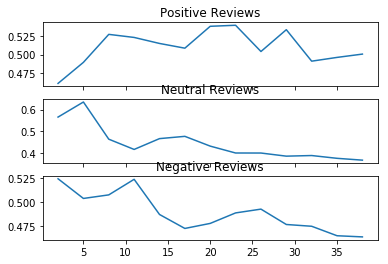

In [92]:
# Show graph

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

limit=40; start=2; step=3;
x = range(start, limit, step)
ax[0].plot(x, coherence_values_pos, label="wow")
ax[0].set_title("Positive Reviews")
ax[1].plot(x, coherence_values_neu)
ax[1].set_title("Neutral Reviews")
ax[2].plot(x, coherence_values_neg)
ax[2].set_title("Negative Reviews")

-  20 topics for positive reviews
-  5 topics for neutral reviews
-  11 topics for negative reviews

In [93]:
print(list(zip(range(len(coherence_values_pos)), x)))

[(0, 2), (1, 5), (2, 8), (3, 11), (4, 14), (5, 17), (6, 20), (7, 23), (8, 26), (9, 29), (10, 32), (11, 35), (12, 38)]


In [94]:
lsi_model_pos_best = model_list_pos[6]
lsi_model_neu_best = model_list_neu[1]
lsi_model_neg_best = model_list_neg[11]

In [95]:
lsi_model_pos_best.show_topics()[:5]

[(0,
  '0.271*"doctor" + 0.229*"great" + 0.216*"love" + 0.199*"easy" + 0.194*"info" + 0.179*"need" + 0.170*"good" + 0.166*"information" + 0.165*"make" + 0.157*"medical"'),
 (1,
  '-0.702*"doctor" + 0.306*"great" + -0.227*"love" + 0.155*"work" + 0.140*"feature" + 0.112*"health" + 0.104*"update" + -0.102*"easy" + 0.093*"dropbox" + 0.089*"issue"'),
 (2,
  '0.671*"easy" + -0.314*"info" + -0.259*"doctor" + 0.249*"love" + 0.218*"make" + -0.137*"medical" + 0.118*"good" + 0.116*"information" + 0.097*"find" + -0.093*"iphone"'),
 (3,
  '0.795*"love" + -0.254*"doctor" + -0.227*"great" + -0.213*"easy" + -0.197*"good" + -0.149*"information" + 0.113*"see" + -0.107*"make" + 0.081*"info" + -0.074*"need"'),
 (4,
  '0.730*"great" + -0.284*"good" + 0.194*"love" + 0.190*"info" + -0.175*"use" + -0.144*"need" + -0.140*"log" + -0.138*"find" + -0.098*"touch_id" + -0.097*"feature"')]

In [96]:
lsi_model_neu_best.show_topics()[:5]

[(0,
  '0.231*"work" + 0.226*"see" + 0.214*"appointment" + 0.208*"make" + 0.191*"doctor" + 0.179*"need" + 0.174*"time" + 0.142*"not" + 0.142*"good" + 0.133*"datum"'),
 (1,
  '0.405*"datum" + -0.282*"appointment" + 0.178*"could" + 0.171*"not" + -0.165*"time" + 0.158*"health" + -0.155*"doctor" + 0.144*"report" + -0.138*"make" + 0.137*"level"'),
 (2,
  '-0.445*"appointment" + 0.408*"password" + 0.281*"claim" + -0.175*"make" + 0.145*"user" + -0.129*"provider" + 0.123*"time" + 0.116*"issue" + -0.116*"work" + 0.113*"log"'),
 (3,
  '0.309*"work" + -0.210*"see" + -0.197*"claim" + 0.187*"info" + 0.173*"bug" + 0.167*"program" + 0.163*"computer" + 0.161*"icloud" + 0.158*"mac" + -0.152*"not"'),
 (4,
  '-0.376*"password" + -0.199*"good" + 0.188*"need" + 0.187*"add" + -0.164*"provider" + -0.157*"take" + -0.154*"log" + 0.141*"want" + -0.136*"name" + 0.130*"contact"')]

In [97]:
lsi_model_neg_best.show_topics()[:5]

[(0,
  '0.315*"work" + 0.270*"not" + 0.265*"try" + 0.175*"log" + 0.174*"update" + 0.165*"go" + 0.156*"time" + 0.142*"even" + 0.138*"can" + 0.134*"need"'),
 (1,
  '0.754*"not" + 0.428*"can" + -0.228*"work" + 0.212*"do" + -0.086*"try" + -0.084*"update" + 0.079*"be" + -0.078*"need" + -0.075*"take" + -0.071*"time"'),
 (2,
  '-0.756*"work" + 0.233*"doctor" + 0.165*"go" + -0.149*"log" + -0.147*"try" + -0.135*"password" + 0.131*"find" + 0.110*"see" + -0.102*"login" + 0.100*"take"'),
 (3,
  '-0.490*"log" + -0.463*"password" + 0.407*"work" + -0.325*"try" + -0.172*"get" + 0.155*"not" + -0.125*"login" + -0.113*"account" + 0.093*"doctor" + 0.089*"update"'),
 (4,
  '0.623*"update" + -0.487*"try" + 0.260*"password" + 0.146*"log" + -0.137*"doctor" + -0.129*"even" + -0.119*"find" + -0.114*"call" + 0.098*"sync" + 0.094*"support"')]